# 4a. Handling data with PyTorch

We will now look at the `torch.utils.data` package and explore how PyTorch supports us in handling training and validation data.

## Key concepts of this section

1. `torch.utils.data.Dataset`
2. `torch.utils.data.DataLoader`
3. **Data transforms**

In [1]:
from typing import Tuple, List

import torch
import torchvision
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from workshop import data
import helper

## 1. Dataset

A [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) is an abstraction layer that handles reading data from specified source. This could mean reading images from the file system, strings from a NoSQL data base, ...

In `PyTorch`, a (map-style) dataset is a class that implements the `__getitem__(self, key)` method, which returns $(x, y)$ and `__len__(self)`.

### Exercises

For this set of exercises, you are given the raw data already (kindly provided by the `torchvision` library). To check other built-in datasets refer to [PyTorch documentation](https://pytorch.org/docs/stable/torchvision/datasets.html).

### Exercise 1:
Create your own PyTorch MNIST dataset.

Assume that `x` is a tensor of `28x28` tensors (MNIST image pixels) and `y` is a tensor of labels (0-9) in the same order as `x`.

**targets:** tensor([5, 0, 4, 1])

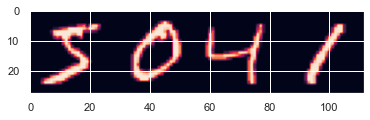

In [2]:
class MnistDataSet:
    def __init__(self, x, y):
        self.x, self.y = x, y
    
    def __getitem__(self, key) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.x[key], self.y[key]
    
    def __len__(self):
        return len(self.x)
    
x_train, y_train = torch.load(data.DATA_PATH / "MNIST/processed/training.pt")

train_mnist = MnistDataSet(x_train.float(), y_train)
assert len(train_mnist) == 60000

x, y = train_mnist[:4]

torch.testing.assert_allclose(y, [5, 0, 4, 1])
assert x.shape == (4, 28, 28)

helper.show_batch_of_data(x, y)

### Exercise 2:
Refactor your data set by moving the call to `torch.load` to the constructor.

**targets:** tensor([5, 0, 4, 1])

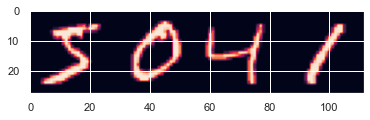

In [3]:
class MnistDataSet:
    def __init__(self, train=True):
        subset = "training" if train else "test"
        self.x, self.y = torch.load(data.DATA_PATH / f"MNIST/processed/{subset}.pt")
        self.x = self.x.float()
    
    def __getitem__(self, key) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.x[key], self.y[key]
    
    def __len__(self):
        return len(self.x)
    
train_mnist = MnistDataSet()
assert len(train_mnist) == 60000

x, y = train_mnist[:4]

torch.testing.assert_allclose(y, [5, 0, 4, 1])
assert x.shape == (4, 28, 28)

helper.show_batch_of_data(x, y)

### Exercise 3:

There really isn't much more to a dataset than this. Check the MNIST dataset as it is provided by the `torchvision` library and see if it does the same thing as ours.

In [4]:
train_mnist = torchvision.datasets.MNIST(data.DATA_PATH, download=True, train=True)

# Answer: Does not handle slices and returns PIL.Image instead of tensor.

## 2. Data loader

A dataset knows where input data resides and how to read it. But during training we want to do much more than just reading data, for example:

1. Data batching
1. Data augmentation
1. Hard-example mining
1. Lift data imbalance
1. ...

This is where [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) comes into play. PyTorch (and its application libraries) offers a wide range of data loaders that may be used to address the above points. Essentially though, they provide a means to iterate over a Dataset.

### Exercise 4:

Implement an MNIST dataloader that returns random batches of data 

Epoch #1


**targets:** tensor([5, 0, 3, 5])

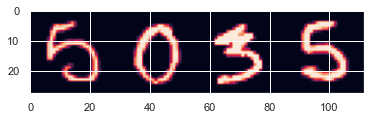

**targets:** tensor([0, 5, 0, 0])

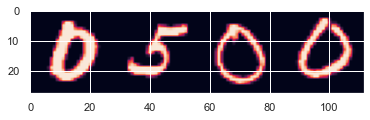

Epoch #2


**targets:** tensor([4, 4, 4, 8])

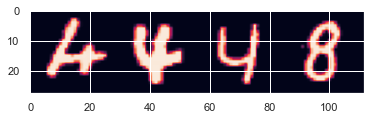

**targets:** tensor([9, 2, 2, 9])

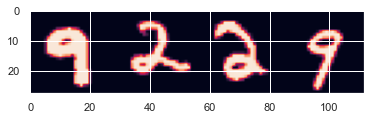

In [5]:
import random

class MnistDataLoader:
    def __init__(self, dataset, batch_size, shuffle):
        self.dataset, self.batch_size, self.shuffle = dataset, batch_size, shuffle
    
    def __iter__(self):
        self.idx = list(range(len(self.dataset)))
        if self.shuffle:
            random.shuffle(self.idx)
        return self
    
    def __next__(self):
        if self.idx:
            batch, self.idx = self.idx[:self.batch_size], self.idx[self.batch_size:]
            return self.dataset[batch]
        raise StopIteration()

n_epochs = 2
for epoch in range(n_epochs):
    print(f"Epoch #{epoch+1}")
    dl = MnistDataLoader(MnistDataSet(train=False), 4, True)
    helper.show_first_n_batches(dl, n=2) 


## 3. Data transforms

Beyond providing data in random batches, we can extend our data loader to perform transformations on $x$ and $y$. 

These transformation can be used for data preparation (like normalization) and augmentation.

Because of the very simple tranformer api, it is very easy to create your own transformers or to throw in, say, your favourite image augmentation library, e.g. [albumentations](https://albumentations.ai/).

Of course, the PyTorch application libraries already provide a great selection of transforms, e.g. for [images](https://pytorch.org/docs/stable/torchvision/transforms.html) or [audio](https://pytorch.org/audio/stable/transforms.html).

Let's take a look at one of them, namely the [Compose transform](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose):

- We notice that it has a simple implementation and it receives only $x$ as an argument.
- Maybe this is enough for our use case. But in case we are dealing with segmentation masks, we will have to impose our own implementation.

### Exercise 5:

**Data normalization.** The tensors that come out of our data loader are still pixel values between 0.0 and 255.0.

Calculate the data's `mean` and `std` and add a transform that rescales the images. Extend the `MnistDataLoader` to be able to use such a transform.

In [6]:
class MnistDataLoader:
    def __init__(self, dataset, batch_size, shuffle, transform=None):
        self.dataset, self.batch_size, self.shuffle, self.transform = dataset, batch_size, shuffle, transform
    
    def __iter__(self):
        self.idx = list(range(len(self.dataset)))
        if self.shuffle:
            random.shuffle(self.idx)
        return self
    
    def __next__(self):
        if self.idx:
            batch, self.idx = self.idx[:self.batch_size], self.idx[self.batch_size:]
            x, y = self.dataset[batch]
            if self.transform:
                return self.transform(x, y)
            return x, y
        
        raise StopIteration()

class ImageNormalizer:
    def __init__(self, mean, std):
        self.mean, self.std = mean, std
    
    def __call__(self, x, y):
        return (x - self.mean).div_(self.std), y

mean = x_train.double().mean()
std = x_train.double().std()

print(f"Global mean: {mean.item()}")
print(f"Global std: {std.item()}")

dl = MnistDataLoader(MnistDataSet(train=False), 4, True, ImageNormalizer(mean, std))
x, y = next(iter(dl))
print(x.mean(), x.std())

Global mean: 33.318421449829934
Global std: 78.56749083061408
tensor(-0.0803) tensor(0.9152)


### (optional) Exercise 6

Write a transform that performs a horizontal flip for digits 0, 1, 8.

Epoch #1


**targets:** tensor([7, 2, 1, 0, 4, 1, 4, 9])

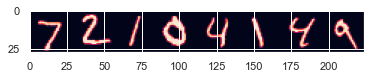

**targets:** tensor([5, 9, 0, 6, 9, 0, 1, 5])

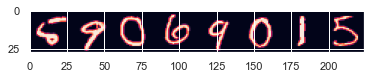

Epoch #2


**targets:** tensor([7, 2, 1, 0, 4, 1, 4, 9])

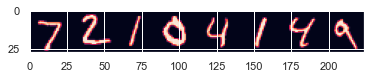

**targets:** tensor([5, 9, 0, 6, 9, 0, 1, 5])

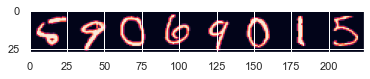

In [7]:
class DigitFlipper:
    def __init__(self, digits_to_flip: List[int], prob=0.5):
        self.digits_to_flip, self.prob = digits_to_flip, prob
        
    def __call__(self, x, y):
        for i, digit in enumerate(y.numpy()):
            if digit in self.digits_to_flip and random.random() <= self.prob:
                x[i] = x[i].flip(-1)
        return x, y
    

n_epochs = 2
for epoch in range(n_epochs):
    print(f"Epoch #{epoch+1}")
    dl = MnistDataLoader(MnistDataSet(train=False), 8, False, transform=DigitFlipper([0, 1, 8], 0.5))
    helper.show_first_n_batches(dl, n=2) 